### Train a 1D CNN model to classify the synthetic ECG data and test the model on real data 

In [1]:
from synDataLoader import syn_mitbih, mixed_mitbih
from DataLoader import mitbih_train, mitbih_test

In [2]:
mixed_ecg = mixed_mitbih(real_samples = 200, syn_samples = 800)

data shape is (4000, 1, 187)
labels shape is (4000,)
The dataset including 800 class 0, 800 class 1, 800 class 2, 800 class 3, 800 class 4
X_train shape is (1000, 1, 187)
y_train shape is (1000,)
The dataset including 200 class 0, 200 class 1, 200 class 2, 200 class 3, 200 class 4
data shape is (5000, 1, 187)
labels shape is (5000,)


In [13]:
syn_ecg = syn_mitbih(n_samples=800, reshape=True)

data shape is (4000, 1, 187)
labels shape is (4000,)
The dataset including 800 class 0, 800 class 1, 800 class 2, 800 class 3, 800 class 4


In [14]:
real_ecg = mitbih_train(n_samples=200, oneD=True)

X_train shape is (1000, 1, 187)
y_train shape is (1000,)
The dataset including 200 class 0, 200 class 1, 200 class 2, 200 class 3, 200 class 4


In [11]:
real_test_ecg = mitbih_test(n_samples=500, oneD=True)

X_test shape is (2500, 1, 187)
y_test shape is (2500,)
The dataset including 18118 class 0, 556 class 1, 1448 class 2, 162 class 3, 1608 class 4


In [12]:
from torch.utils import data
syn_loader = data.DataLoader(syn_ecg, batch_size=32, num_workers=4, shuffle=True)
real_loader = data.DataLoader(real_ecg, batch_size=32, num_workers=4, shuffle=True)
mixed_loader = data.DataLoader(mixed_ecg, batch_size=32, num_workers=4, shuffle=True)
test_real_loader = data.DataLoader(real_test_ecg, batch_size=32, num_workers=4, shuffle=True)

In [4]:
#Define a simple CNN classifier 
import torch
import torch.nn as nn
import torch.nn.functional as F


class ECG_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 6)
        self.conv2 = nn.Conv1d(64, 64, 6)
        self.conv3 = nn.Conv1d(64, 64, 3)
        self.dropout = nn.Dropout(p=0.5) 
        self.pool = nn.MaxPool1d(3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1152, 100)
        self.fc2 = nn.Linear(100, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [5]:
def train(model, train_data_loader, test_data_loader, epochs, criterion, optimizer, filename="test_cm"):
    for epoch in range(epochs):  # loop over the dataset multiple times
        model.train()
        total_loss = 0.0
        total = 0
        correct = 0

        for i, data in enumerate(train_data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_loss = total_loss / len(train_data_loader)
        epoch_train_acc = correct / total
        print(f'Epoch {epoch + 1}, train loss = {epoch_train_loss}, train acc = {epoch_train_acc}')

        if (epoch+1) % 5 == 0:
            _eval(model, test_data_loader, criterion, epoch)
#             _eval_single_class(model, test_data_loader, criterion, epoch)
            
    _final_eval(model, test_data_loader, criterion, filename)

    print('Finished Training and testing')

In [6]:
def _eval(model, real_test_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_test_loss = total_loss / len(real_test_loader)
        epoch_test_acc = correct / total
    
    print('=====================================================')
    print(f'Epoch {epoch+1}, test loss = {epoch_test_loss}, test acc = {epoch_test_acc}')
    print('=====================================================')

In [7]:
classes = ['Non-Ectopic Beats', 'Superventrical Ectopic', 'Ventricular Beats', 'Unknown', 'Fusion Beats']
classes_idx = ['1','2','3','4','5']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

In [8]:
def _eval_single_class(model, real_test_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            total_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                       accuracy))

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def _final_eval(model, real_test_loader, criterion, filename="test_cm"):
    nb_classes = 5
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    target_names = classes
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()
            
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,predictions.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
            
            y_preds.append(predictions)
            y_trues.append(labels)
            
    # Confusion matrix
    cm=confusion_matrix(lbllist.numpy(), predlist.numpy())
    print(cm)
    cm_df = pd.DataFrame(cm,
                     index = classes_idx, 
                     columns = classes_idx)
    fig = plt.figure(figsize=(6.5,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
#     plt.title('ECG classification Accuracy')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout() # keeps labels from being cutoff when saving as pdf
    plt.savefig(f'{filename}.pdf')
    plt.show()
    
    # Per-class accuracy
    class_accuracy = 100*cm.diagonal() / cm.sum(1)
    print(class_accuracy)
    
    #print classification report 
    y_preds_flatten = [label for sublist in y_preds for label in sublist]
    y_trues_flatten = [label for sublist in y_trues for label in sublist]
    
    print(classification_report(y_trues_flatten, y_preds_flatten, target_names=classes))

Epoch 1, train loss = 1.60620810015042, train acc = 0.2504
Epoch 2, train loss = 1.5851248732276602, train acc = 0.3808
Epoch 3, train loss = 1.5125299246106625, train acc = 0.3914
Epoch 4, train loss = 1.2398018082856768, train acc = 0.6048
Epoch 5, train loss = 0.7821619958706093, train acc = 0.721
Epoch 5, test loss = 1.0533114208406398, test acc = 0.648
Epoch 6, train loss = 0.544384068908775, train acc = 0.8064
Epoch 7, train loss = 0.42651095051609805, train acc = 0.8494
Epoch 8, train loss = 0.3527215867749843, train acc = 0.8788
Epoch 9, train loss = 0.3138039874052538, train acc = 0.8894
Epoch 10, train loss = 0.28509140265258653, train acc = 0.9008
Epoch 10, test loss = 1.0568790569708513, test acc = 0.7144
Epoch 11, train loss = 0.24579492511726253, train acc = 0.9182
Epoch 12, train loss = 0.22867385173490498, train acc = 0.924
Epoch 13, train loss = 0.21258013115054192, train acc = 0.9284
Epoch 14, train loss = 0.19234463959575407, train acc = 0.938
Epoch 15, train loss = 

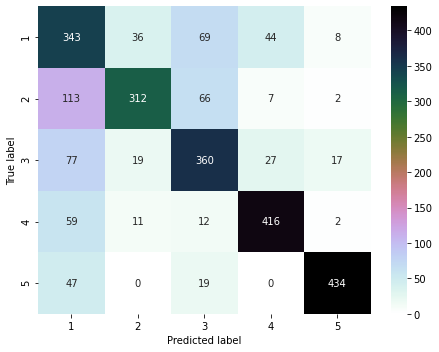

[68.6 62.4 72.  83.2 86.8]
                        precision    recall  f1-score   support

     Non-Ectopic Beats       0.54      0.69      0.60       500
Superventrical Ectopic       0.83      0.62      0.71       500
     Ventricular Beats       0.68      0.72      0.70       500
               Unknown       0.84      0.83      0.84       500
          Fusion Beats       0.94      0.87      0.90       500

              accuracy                           0.75      2500
             macro avg       0.77      0.75      0.75      2500
          weighted avg       0.77      0.75      0.75      2500

Finished Training and testing


In [42]:
# Define training hyperparameters
import torch.optim as optim
ECG_model = ECG_Net()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, syn_loader, test_real_loader, 50, criterion, optimizer, filename='synthetic_data')

Epoch 1, train loss = 1.6086999163617228, train acc = 0.2
Epoch 2, train loss = 1.6002482679875647, train acc = 0.3136
Epoch 3, train loss = 1.5826943645388742, train acc = 0.3572
Epoch 4, train loss = 1.5276936198321764, train acc = 0.3876
Epoch 5, train loss = 1.3766225827009502, train acc = 0.435
Epoch 5, test loss = 1.364540021311006, test acc = 0.5088
Epoch 6, train loss = 1.2033722409980068, train acc = 0.5278
Epoch 7, train loss = 1.0813648935646372, train acc = 0.6036
Epoch 8, train loss = 1.003552432729972, train acc = 0.6346
Epoch 9, train loss = 0.9400633253499634, train acc = 0.6644
Epoch 10, train loss = 0.8950387562539206, train acc = 0.676
Epoch 10, test loss = 0.9767127220342241, test acc = 0.6856
Epoch 11, train loss = 0.8565026762314945, train acc = 0.6892
Epoch 12, train loss = 0.8320794578046257, train acc = 0.703
Epoch 13, train loss = 0.7935027608727895, train acc = 0.7182
Epoch 14, train loss = 0.7660970896443784, train acc = 0.7238
Epoch 15, train loss = 0.74148

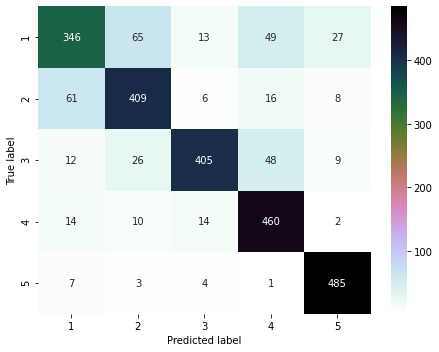

[69.2 81.8 81.  92.  97. ]
                        precision    recall  f1-score   support

     Non-Ectopic Beats       0.79      0.69      0.74       500
Superventrical Ectopic       0.80      0.82      0.81       500
     Ventricular Beats       0.92      0.81      0.86       500
               Unknown       0.80      0.92      0.86       500
          Fusion Beats       0.91      0.97      0.94       500

              accuracy                           0.84      2500
             macro avg       0.84      0.84      0.84      2500
          weighted avg       0.84      0.84      0.84      2500

Finished Training and testing


In [43]:
# Define training hyperparameters
import torch.optim as optim
ECG_model = ECG_Net()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, real_loader, test_real_loader, 50, criterion, optimizer, filename='real_data')

Epoch 1, train loss = 1.6085652914133166, train acc = 0.2
Epoch 2, train loss = 1.6075310006018668, train acc = 0.2
Epoch 3, train loss = 1.6064074427945754, train acc = 0.201
Epoch 4, train loss = 1.6054312299652216, train acc = 0.201
Epoch 5, train loss = 1.6037455203292086, train acc = 0.21
Epoch 5, test loss = 1.606635220277894, test acc = 0.2
Epoch 6, train loss = 1.6025521590879381, train acc = 0.245
Epoch 7, train loss = 1.599898114660906, train acc = 0.236
Epoch 8, train loss = 1.5974431201773853, train acc = 0.294
Epoch 9, train loss = 1.5949521045456783, train acc = 0.377
Epoch 10, train loss = 1.5916360147282949, train acc = 0.401
Epoch 10, test loss = 1.5982304131620597, test acc = 0.358
Epoch 11, train loss = 1.585798442481177, train acc = 0.445
Epoch 12, train loss = 1.5798925775286776, train acc = 0.465
Epoch 13, train loss = 1.5730181735827482, train acc = 0.449
Epoch 14, train loss = 1.5640193446732702, train acc = 0.409
Epoch 15, train loss = 1.5507902619479508, train

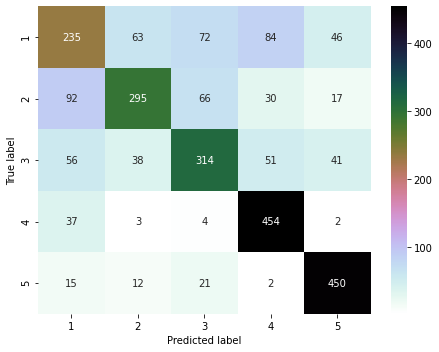

[47.  59.  62.8 90.8 90. ]
                        precision    recall  f1-score   support

     Non-Ectopic Beats       0.54      0.47      0.50       500
Superventrical Ectopic       0.72      0.59      0.65       500
     Ventricular Beats       0.66      0.63      0.64       500
               Unknown       0.73      0.91      0.81       500
          Fusion Beats       0.81      0.90      0.85       500

              accuracy                           0.70      2500
             macro avg       0.69      0.70      0.69      2500
          weighted avg       0.69      0.70      0.69      2500

Finished Training and testing


In [11]:
# Define training hyperparameters
import torch.optim as optim
ECG_model = ECG_Net()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, real_loader, test_real_loader, 50, criterion, optimizer, filename='real_data_small')

Epoch 1, train loss = 1.6008325115821889, train acc = 0.2106
Epoch 2, train loss = 1.5654081582185004, train acc = 0.267
Epoch 3, train loss = 1.4367275804546036, train acc = 0.3972
Epoch 4, train loss = 1.0119174018779082, train acc = 0.6616
Epoch 5, train loss = 0.7349427546999359, train acc = 0.7538
Epoch 5, test loss = 0.9865394064069709, test acc = 0.656
Epoch 6, train loss = 0.6327807666027891, train acc = 0.7932
Epoch 7, train loss = 0.5717997108935874, train acc = 0.8162
Epoch 8, train loss = 0.538641404055691, train acc = 0.8292
Epoch 9, train loss = 0.5020559541989801, train acc = 0.8472
Epoch 10, train loss = 0.4905172956968787, train acc = 0.8476
Epoch 10, test loss = 0.8770311710133207, test acc = 0.7204
Epoch 11, train loss = 0.45231605527402696, train acc = 0.869
Epoch 12, train loss = 0.42465884986300034, train acc = 0.8724
Epoch 13, train loss = 0.4175453539356129, train acc = 0.8748
Epoch 14, train loss = 0.4120304290281223, train acc = 0.877
Epoch 15, train loss = 0.

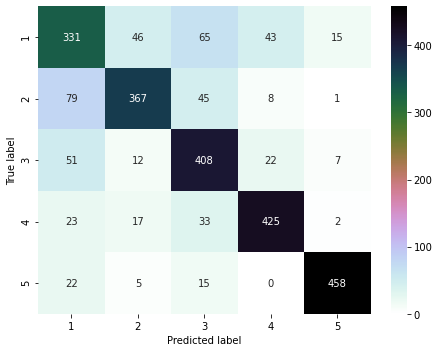

[66.2 73.4 81.6 85.  91.6]
                        precision    recall  f1-score   support

     Non-Ectopic Beats       0.65      0.66      0.66       500
Superventrical Ectopic       0.82      0.73      0.78       500
     Ventricular Beats       0.72      0.82      0.77       500
               Unknown       0.85      0.85      0.85       500
          Fusion Beats       0.95      0.92      0.93       500

              accuracy                           0.80      2500
             macro avg       0.80      0.80      0.80      2500
          weighted avg       0.80      0.80      0.80      2500

Finished Training and testing


In [13]:
import torch.optim as optim
ECG_model = ECG_Net()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, mixed_loader, test_real_loader, 50, criterion, optimizer, filename='mixed_data')